In [1]:
import batoid
import batoid_rubin
import numpy as np
import matplotlib.pyplot as plt
import yaml
import ipywidgets
from pathlib import Path
from tqdm.notebook import tqdm

from lsst.ts.ofc import OFC, OFCData, StateEstimator, SensitivityMatrix
import lsst.obs.lsst as obs_lsst
from lsst.afw.cameraGeom import FIELD_ANGLE

ofc_data = OFCData('lsst')


In [2]:
def doubleZernike(
    optic, field, wavelength, rings=7, spokes=25, jmax=22, kmax=22, 
    **kwargs
):

    if spokes is None:
        spokes = 2*rings+1

    Li, w = np.polynomial.legendre.leggauss(rings)
    radii = np.sqrt((1+Li)/2)*field
    w *= np.pi/(2*spokes)
    azs = np.linspace(0, 2*np.pi, spokes, endpoint=False)
    radii, azs = np.meshgrid(radii, azs)
    w = np.broadcast_to(w, radii.shape)
    radii = radii.ravel()
    azs = azs.ravel()
    w = w.ravel()
    thx = radii * np.cos(azs)
    thy = radii * np.sin(azs)
    coefs = []
    for thx_, thy_ in zip(thx, thy):
        coefs.append(batoid.zernike(
            optic, 
            thx_, 
            thy_,
            wavelength,
            jmax=jmax,
            eps=0.61,
            nx=255
        ))
    coefs = np.array(coefs)

    import galsim
    basis = galsim.zernike.zernikeBasis(
        kmax, thx, thy, R_outer=field
    )
    dzs = np.dot(basis, coefs*w[:,None])/np.pi

    return dzs

In [3]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [4]:
fieldx, fieldy = zip(*ofc_data.gq_field_angles)

In [5]:
path = '/sdf/home/g/gmegias/aos/ts_ofc/policy/lsst/'
with open(path + f"senM_gq_35_19_50.yaml") as f:
    sen = np.array(yaml.safe_load(f))
print(sen.shape)
# 35 field points x 19 zernikes x 50 dof

(35, 19, 50)


In [6]:
# convert from batoid to zemax coords
# flip input x => -x
# flip output image, corresponds to flipping signs of following Zernikes
swap = [2, 5, 8, 10, 13, 15, 16, 18, 20]

In [28]:
fiducial = batoid.Optic.fromYaml("LSST_r.yaml")
wavelength = 0.622  # micron
z0 = np.zeros((35, 23))
for i, (x, y) in tqdm(enumerate(zip(fieldx, fieldy)), total=35):
    z0[i] = batoid.zernike(
        fiducial, 
        np.deg2rad(x), 
        np.deg2rad(y),
        wavelength*1e-6,
        jmax=22,
        eps=0.61,
        nx=255
    )*wavelength  # waves -> microns
z0[:, swap] *= -1
z0 = z0[:, 4:23]

  0%|          | 0/35 [00:00<?, ?it/s]

In [8]:
dz = np.zeros((35, 19, 50))
for idof in tqdm(range(50)):
    z1 = np.zeros((35, 23))
    arr = np.zeros(50)
    arr[idof] = 1.0
    builder = batoid_rubin.LSSTBuilder(fiducial).with_aos_dof(arr)
    telescope = builder.build()
    for i, (x, y) in enumerate(zip(fieldx, fieldy)):
        z1[i, :] = batoid.zernike(
            telescope, 
            np.deg2rad(x), 
            np.deg2rad(y),
            wavelength*1e-6,
            jmax=22,
            eps=0.61,
            nx=255
        )*wavelength  # waves -> microns
    z1[:, swap] *= -1
    z1 = z1[:, 4:23]    
    dz[:, :, idof] = z1-z0


  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
import galsim


def get_fiducial(band):
    fiducial = batoid.Optic.fromYaml(f"LSST_{band}.yaml")
    wavelength = {
        "u": 0.365,
        "g": 0.480,
        "r": 0.622,
        "i": 0.754,
        "z": 0.869,
        "y": 0.971,
    }[band]
    return fiducial, wavelength

def get_dz0(band, jmax=22, kmax=15):
    fiducial, wavelength = get_fiducial(band)
    return doubleZernike(
        fiducial,
        field=np.deg2rad(1.75),
        wavelength=wavelength*1e-6,  # nm -> m
        eps=0.61,
        jmax=jmax,
        kmax=kmax
    )

def get_sensitivity_dz(band, dof_idx, jmax=22, kmax=15):
    ndof = len(dof_idx)
    A = np.empty((ndof, kmax+1, jmax+1))
    fiducial, wavelength = get_fiducial(band)
    swap = [2, 5, 8, 10, 13, 15, 16, 18, 20]
    dz0 = get_dz0(band, jmax, kmax)
    dz0[:, swap] *= -1
    for iarr, idof in enumerate(dof_idx):
        arr = np.zeros(50)

        arr[idof] = 1
        fiducial, wavelength = get_fiducial(band)
        builder = batoid_rubin.LSSTBuilder(fiducial).with_aos_dof(arr)
        telescope = builder.build()
        dz1 = doubleZernike(
            telescope,
            field=np.deg2rad(1.75),
            wavelength=wavelength*1e-6,  # nm -> m
            eps=0.61,
            jmax=jmax,
            kmax=kmax,
        )
    
        dz1[:, swap] *= -1
        A[iarr] = (dz1-dz0)/1

    return A*0.622

def evaluate_sensitivity(A, rotation_angle, dofs):
    # Retrieve field angles for each GQ point from ofc_data
    field_x, field_y = zip(*ofc_data.gq_field_angles)

    rotated_sensitivity_matrix = np.array(
        [
            np.array(
                [
                    zk.coef
                    for zk in galsim.zernike.DoubleZernike(
                        A[..., idofidx],
                        # Rubin annuli
                        uv_inner=0.0,
                        uv_outer=1.75,
                        xy_inner=0.612 * 4.18,
                        xy_outer=4.18,
                    ).rotate(theta_uv=rotation_angle)(field_x, field_y)
                ]
            )
            for idofidx in dofs
        ]
    )

    return rotated_sensitivity_matrix



In [44]:
zk1 = intrinsic_r[:, 6]
zk1.shape

(31,)

In [77]:
fiducial = batoid.Optic.fromYaml("LSST_g.yaml")
wavelength = 0.622  # micron
z0 = np.zeros((35, 23))
for i, (x, y) in tqdm(enumerate(zip(fieldx, fieldy)), total=35):
    z0[i] = batoid.wavefront(
        fiducial, 
        np.deg2rad(x), 
        np.deg2rad(y),
        wavelength*1e-6,
        jmax=22,
        eps=0.61,
        nx=255
    )*wavelength  # waves -> microns
z0[:, swap] *= -1
z0 = z0[:, 4:23]

  0%|          | 0/35 [00:00<?, ?it/s]

TypeError: wavefront() got an unexpected keyword argument 'jmax'

In [82]:
intrinsic_r = get_dz0('g', jmax=22, kmax=30)
intrinsic_r.shape

(31, 23)

In [95]:
filter_name = 'r'
import ruamel.yaml
import textwrap
intrinsic = get_dz0(filter_name, jmax=22, kmax=30)

with open(f"intrinsic_zernikes_{filter_name}_31_23.yaml", 'w') as yaml_file:
    yaml_file.write(f"--- \n \
    \n # Intrinsic Zk for the {filter_name} band. \
    \n # The first dimension is kmax = 31, corresponds to number of Zernike \
    \n # polynomials used to measure wavefront variation accross the pupil. \
    \n # The second dimension is jmax = 23, corresponds to number of Zernike \
    \n # polynomials used to measure wavefront variation accross the field. In um (Z0-Z22). \
    \n \n")

    yaml = ruamel.yaml.YAML()
    yaml.indent(offset=2)
    yaml.width = 100

    for sublist in intrinsic.tolist():
        formatted_sublist = textwrap.fill('- [' + ', '.join(map(str, sublist)), width=100, subsequent_indent='  ')
        yaml_file.write(formatted_sublist + '] \n')


from astropy.io import fits
prihdr = fits.Header()
prihdr['Content'] = 'Intrinsic zernikes (k, j)'
prihdr['Dim'] = '(31,23)'
hdu = fits.PrimaryHDU(intrinsic, header=prihdr)
hdu.writeto(f"intrinsic_zernikes_{filter_name}_31_23.fits", overwrite=True)

In [ ]:
filter_name = 'r'
intrinsic = get_dz0(filter_name, jmax=22, kmax=30)

with open(f"intrinsic_zernikes_{filter_name}_31_23.yaml", 'w') as yaml_file:
    yaml_file.write(f"--- \n \
    \n # Intrinsic Zk for the {filter_name} band. \
    \n # The first dimension is kmax = 31, corresponds to number of Zernike \
    \n # polynomials used to measure wavefront variation accross the pupil. \
    \n # The second dimension is jmax = 23, corresponds to number of Zernike \
    \n # polynomials used to measure wavefront variation accross the field. In um (Z0-Z22). \
    \n \n")
    for sublist in intrinsic.tolist():
        yaml_file.write(f'- {sublist}\n')


from astropy.io import fits
prihdr = fits.Header()
prihdr['Content'] = 'Intrinsic zernikes (k, j)'
prihdr['Dim'] = '(31,23)'
hdu = fits.PrimaryHDU(intrinsic, header=prihdr)
hdu.writeto(f"intrinsic_zernikes_{filter_name}_31_23.fits", overwrite=True)

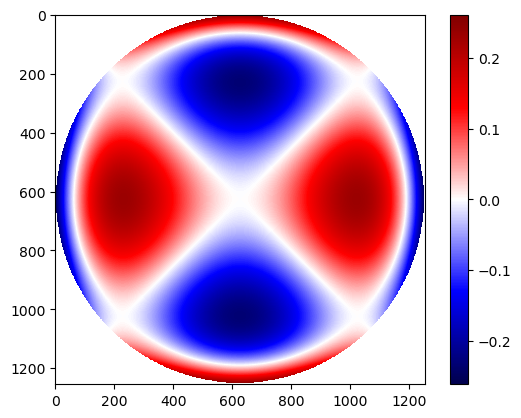

In [80]:
xs = np.linspace(-4.18, 4.18, 1255)
ys =  np.linspace(-4.18, 4.18, 1255)

xs, ys = np.meshgrid(xs, ys)
# Calculate the distances from the center
distances = np.sqrt(xs**2 + ys**2)
# Create a mask for points outside the circle
mask = distances <=  4.18


masked_X = np.ma.masked_where(~mask, xs)
masked_Y = np.ma.masked_where(~mask, ys)
opd = galsim.zernike.Zernike(zk1, R_inner= 0.61 * 4.18, R_outer = 4.18)(masked_X, masked_Y)


plt.imshow(opd, cmap='seismic')
plt.colorbar()

In [8]:
double_sen = get_sensitivity_dz('r', np.arange(50), jmax = 22, kmax=30)
double_sen = np.einsum('ijk->jki', double_sen)
print(double_sen.shape)

(31, 23, 50)


In [9]:
field_sen = evaluate_sensitivity(double_sen, 0.0, np.arange(50))
field_sen = field_sen[..., 4:23]
field_sen = np.einsum('ijk -> jki', field_sen)
print(field_sen.shape)


(35, 19, 50)


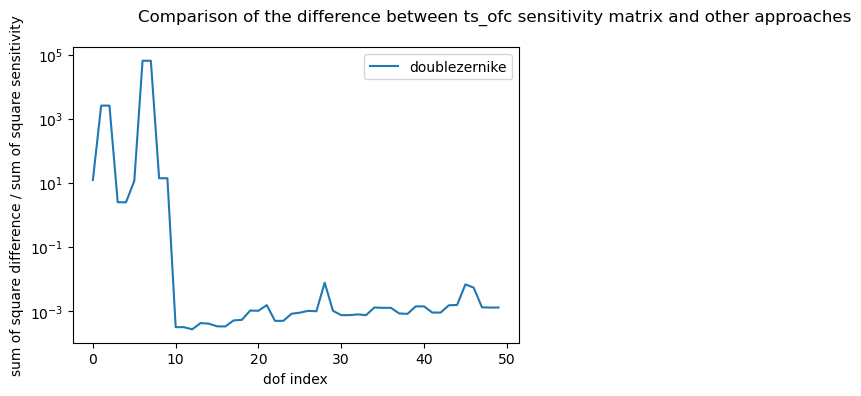

In [10]:
maxs_batoid = []
maxs_dz = []

for idof in range(50):
    #maxs_batoid.append( np.sum((dz[...,idof]-sen[...,idof])**2)/np.sum((sen[...,idof]**2)) )
    maxs_dz.append( np.sum((field_sen[...,idof]-sen[...,idof])**2)/np.sum((sen[...,idof]**2)) )

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
#plt.semilogy(np.arange(50), maxs_batoid, label='batoid')
plt.semilogy(np.arange(50), maxs_dz, label='doublezernike')
plt.xlabel('dof index')
plt.ylabel('sum of square difference / sum of square sensitivity')
plt.legend()



plt.suptitle('Comparison of the difference between ts_ofc sensitivity matrix and other approaches')
plt.tight_layout()

In [ ]:
pwd

: 

In [5]:
with open('/sdf/home/g/gmegias/aos/ts_ofc/policy/lsst/senM_dz_31_23_50.yaml', 'r') as yaml_file:
    double_sen = np.array(yaml.safe_load(yaml_file))

field_sen = evaluate_sensitivity(double_sen, 0.0, np.arange(50))
field_sen = field_sen[..., 4:23]
field_sen = np.einsum('ijk -> jki', field_sen)
print(field_sen.shape)


(35, 19, 50)


In [15]:
with open("senM_dz_31_23_50.yaml", 'w') as yaml_file:
    for sublist in double_sen.tolist():
        yaml_file.write(f'- ')
        for subsublist in sublist:
            yaml_file.write(f'- {subsublist}\n')


from astropy.io import fits
prihdr = fits.Header()
prihdr['Content'] = 'Sensitivity matrix (k, j, dof)'
prihdr['Dim'] = '(31,23,50)'
hdu = fits.PrimaryHDU(double_sen, header=prihdr)
hdu.writeto('senM_dz_31_23_50.fits')

In [32]:
from matplotlib.colors import LogNorm
field_senpi = evaluate_sensitivity(double_sen, np.pi, np.arange(50))
field_senpi = field_senpi[..., 4:23]
field_senpi = np.einsum('ijk -> jki', field_senpi)
print(field_senpi.shape)

field_senpih = evaluate_sensitivity(double_sen, np.pi/2, np.arange(50))
field_senpih = field_senpih[..., 4:23]
field_senpih = np.einsum('ijk -> jki', field_senpih)

field_sen2pi = evaluate_sensitivity(double_sen, np.pi*2, np.arange(50))
field_sen2pi = field_sen2pi[..., 4:23]
field_sen2pi = np.einsum('ijk -> jki', field_sen2pi)


field_senpiq = evaluate_sensitivity(double_sen, np.pi/4, np.arange(50))
field_senpiq = field_senpiq[..., 4:23]
field_senpiq = np.einsum('ijk -> jki', field_senpiq)

field_senpi9 = evaluate_sensitivity(double_sen, np.pi/9, np.arange(50))
field_senpi9 = field_senpi9[..., 4:23]
field_senpi9 = np.einsum('ijk -> jki', field_senpi9)

field_senpi3h = evaluate_sensitivity(double_sen, 3*np.pi/2, np.arange(50))
field_senpi3h = field_senpi3h[..., 4:23]
field_senpi3h = np.einsum('ijk -> jki', field_senpi3h)

field_senpi60 = evaluate_sensitivity(double_sen, np.deg2rad(115), np.arange(50))
field_senpi60 = field_senpi60[..., 4:23]
field_senpi60 = np.einsum('ijk -> jki', field_senpi60)

(35, 19, 50)


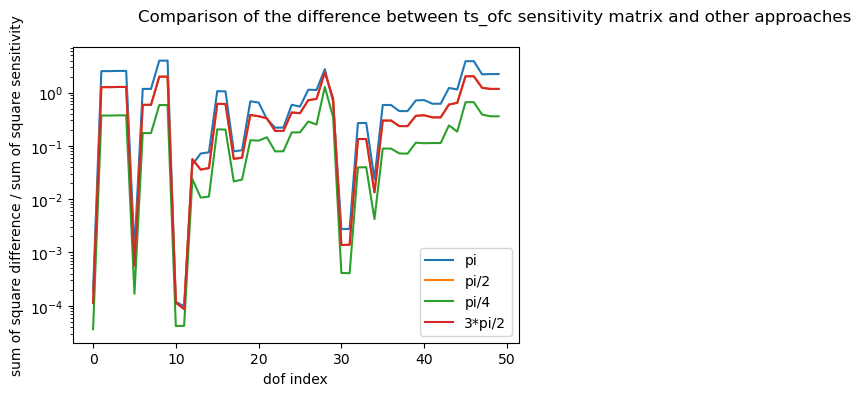

In [13]:
maxs_pi = []
maxs_pih = []
maxs_piq = []
maxs_2pi = []
maxs_pi3h = []

for idof in range(50):
    maxs_pi.append( np.sum((field_senpi[...,idof]-field_sen[...,idof])**2)/np.sum((field_sen[...,idof]**2)) )
    maxs_pih.append( np.sum((field_senpih[...,idof]-field_sen[...,idof])**2)/np.sum((field_sen[...,idof]**2)) )
    maxs_piq.append( np.sum((field_senpiq[...,idof]-field_sen[...,idof])**2)/np.sum((field_sen[...,idof]**2)) )
    maxs_2pi.append( np.sum((field_sen2pi[...,idof]-field_sen[...,idof])**2)/np.sum((field_sen[...,idof]**2)) )
    maxs_pi3h.append( np.sum((field_senpi3h[...,idof]-field_sen[...,idof])**2)/np.sum((field_sen[...,idof]**2)) )

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.semilogy(np.arange(50), maxs_pi, label='pi')
plt.semilogy(np.arange(50), maxs_pih, label='pi/2')
plt.semilogy(np.arange(50), maxs_piq, label='pi/4')
plt.semilogy(np.arange(50), maxs_pi3h, label='3*pi/2')
#plt.semilogy(np.arange(50), maxs_2pi, label='2pi')
plt.xlabel('dof index')
plt.ylabel('sum of square difference / sum of square sensitivity')
plt.legend()



plt.suptitle('Comparison of the difference between ts_ofc sensitivity matrix and other approaches')
plt.tight_layout()

In [18]:
maxs_pi = []
maxs_pih = []
maxs_piq = []
maxs_2pi = []
maxs_pi3h = []

idof = 0

for idzk in [4]:
    maxs_pi.append( (field_senpi[32, idzk,idof]-field_sen[32, idzk,idof]) )
    maxs_pih.append( (field_senpih[32, idzk,idof]-field_sen[32, idzk,idof]) )
    maxs_piq.append( (field_senpiq[32, idzk,idof]-field_sen[32, idzk,idof]) )
    maxs_2pi.append( (field_sen2pi[32, idzk,idof]-field_sen[32, idzk,idof]) )
    maxs_pi3h.append( (field_senpi3h[32, idzk,idof]-field_sen[32, idzk,idof]) )


print(maxs_pi)
print(maxs_pih)
print(maxs_piq)
print(maxs_2pi)
print(maxs_pi3h)

[-0.00019675748116225185]
[-2.6652248794447123e-12]
[4.074982571158061e-05]
[-5.421010862427522e-19]
[-0.00019675746062878795]


In [ ]:
field_senpi60 = evaluate_sensitivity(double_sen, np.deg2rad(115), np.arange(50))
field_senpi60 = field_senpi60[..., 4:23]
field_senpi60 = np.einsum('ijk -> jki', field_senpi60)

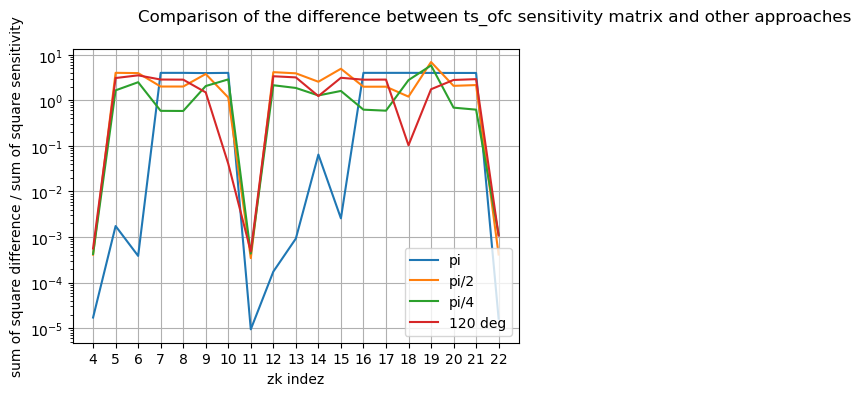

In [38]:
maxs_pi = []
maxs_pih = []
maxs_piq = []
maxs_2pi = []
maxs_pi3h = []
maxs_pi9 = []
maxs_pi60 = []

idof = 29

for idzk in range(19):
    maxs_pi.append( np.sum((field_senpi[:, idzk,idof]-field_sen[:, idzk,idof])**2)/np.sum((field_sen[:, idzk,idof]**2)) )
    maxs_pih.append( np.sum((field_senpih[:, idzk,idof]-field_sen[:, idzk,idof])**2)/np.sum((field_sen[:, idzk,idof]**2)) )
    maxs_piq.append( np.sum((field_senpiq[:, idzk,idof]-field_sen[:, idzk,idof])**2)/np.sum((field_sen[:, idzk,idof]**2)) )
    maxs_2pi.append( np.sum((field_sen2pi[:, idzk,idof]-field_sen[:, idzk,idof])**2)/np.sum((field_sen[:, idzk,idof]**2)) )
    maxs_pi3h.append( np.sum((field_senpi3h[:, idzk,idof]-field_sen[:, idzk,idof])**2)/np.sum((field_sen[:, idzk,idof]**2)) )
    maxs_pi9.append( np.sum((field_senpi9[:, idzk,idof]-field_sen[:, idzk,idof])**2)/np.sum((field_sen[:, idzk,idof]**2)) )
    maxs_pi60.append( np.sum((field_senpi60[:, idzk,idof]-field_sen[:, idzk,idof])**2)/np.sum((field_sen[:, idzk,idof]**2)) )

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.semilogy(np.arange(4,23), maxs_pi, label='pi')
plt.semilogy(np.arange(4,23), maxs_pih, label='pi/2')
plt.semilogy(np.arange(4,23), maxs_piq, label='pi/4')
#plt.semilogy(np.arange(4,23), maxs_pi3h, label='3*pi/2')
#plt.semilogy(np.arange(4,23), maxs_pi9, label='pi/9')
plt.semilogy(np.arange(4,23), maxs_pi60, label='120 deg')
#plt.semilogy(np.arange(4,23), maxs_2pi, label='2pi')
plt.xlabel('zk indez')
plt.ylabel('sum of square difference / sum of square sensitivity')
plt.xticks(np.arange(4,23))
plt.legend()
plt.grid()



plt.suptitle('Comparison of the difference between ts_ofc sensitivity matrix and other approaches')
plt.tight_layout()

In [ ]:
    def dof_state(filter_name, wfe, sensor_names, rotation_angle):
        
        mat_a, field_idx = SensitivityMatrix(ofc_data).evaluate_sensitivity(rotation_angle, sensor_names)

        size_ = mat_a.shape[2]
        mat_a = mat_a.reshape((-1, size_))

        # Check the dimension of pinv A
        num_zk, num_dof = mat_a.shape
        if num_zk < num_dof:
            raise RuntimeError(
                f"Equation number ({num_zk}) < variable number ({num_dof})."
            )

        pinv_a = np.linalg.pinv(mat_a, rcond=RCOND)

        y = (
            np.array(wfe)[:, ofc_data.zn3_idx]
            - ofc_data.get_intrinsic_zk(filter_name, field_idx)
            - ofc_data.y2_correction[np.ix_(field_idx, ofc_data.zn3_idx)]
        )

        y = y.reshape(-1, 1)

        x = pinv_a.dot(y)

        return x.ravel()

NameError: name 'field_sen' is not defined

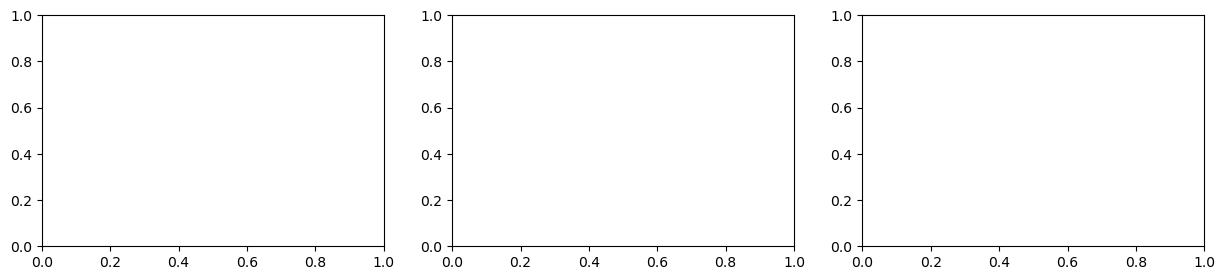

In [25]:
idof = 10
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
colorbar(axes[0].imshow(field_sen[idof,:, :50]))
colorbar(axes[1].imshow(field_senpi[idof,:, :50]))
colorbar(axes[2].imshow(field_sen[idof,:, :50]-field_senpi[idof,:, :50]))
axes[0].set_title("ts_ofc")
axes[1].set_title("double zernikes")
axes[2].set_title("Double zernikes-t")
for ax in axes.ravel():
    ax.set_ylabel("Zernike")
    ax.set_xlabel("DOF")
    ax.set_yticks([4, 8, 12, 16, 18])

In [63]:
ids_swap = [ 3,4,5,6, 12,13,14,15,16,17]
dof_ids = [10,11,12]
field_senpi[:, ids_swap, :] *= -1 

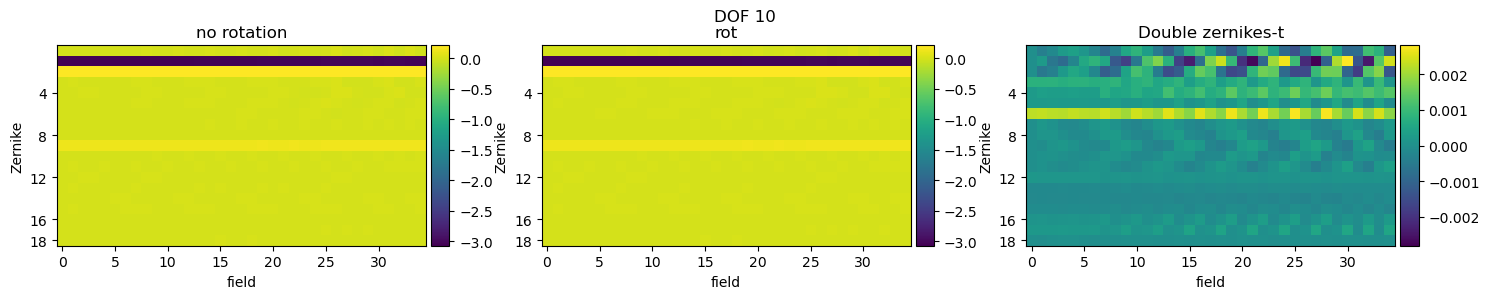

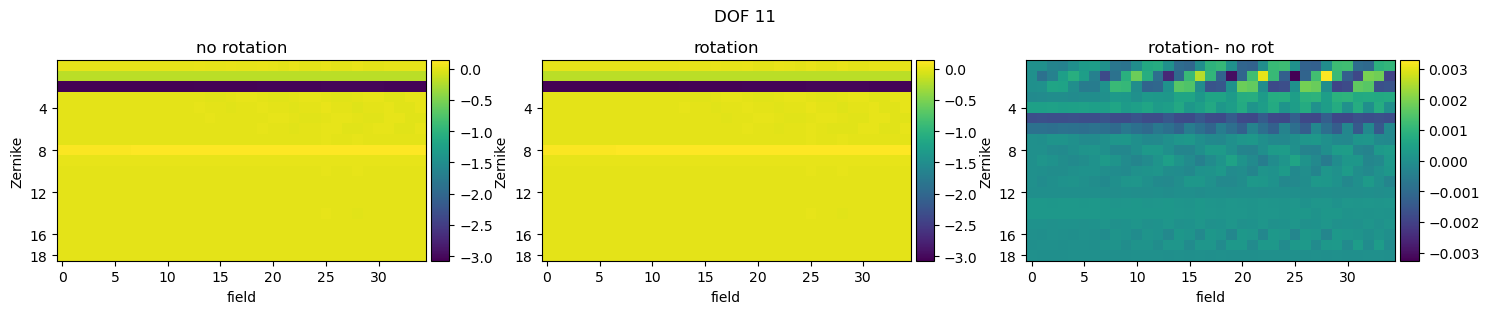

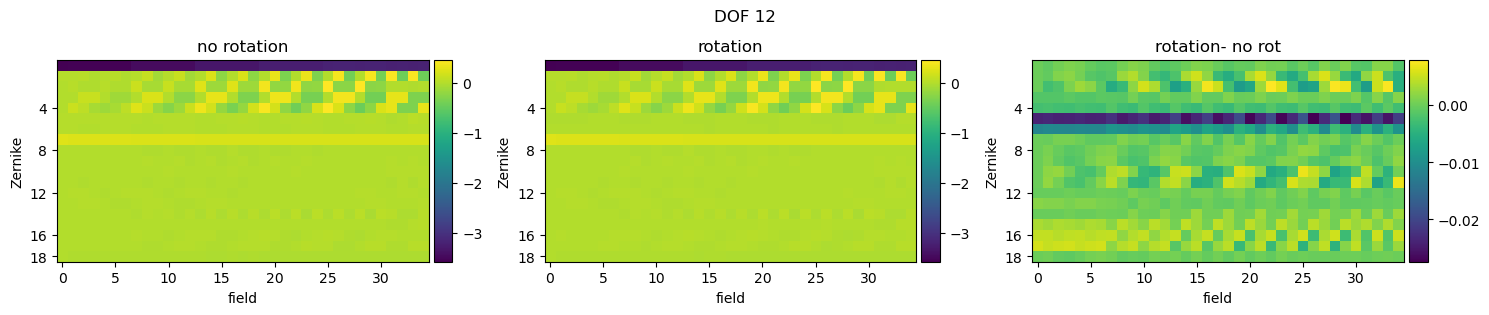

In [64]:
idof = 10
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
colorbar(axes[0].imshow(field_sen[..., idof].T))
colorbar(axes[1].imshow(field_senpi[...,idof].T))
colorbar(axes[2,].imshow(field_senpi[..., idof].T-field_sen[...,idof].T))
axes[0].set_title("no rotation")
axes[1].set_title("rot")
axes[2].set_title("Double zernikes-t")
for ax in axes.ravel():
    ax.set_ylabel("Zernike")
    ax.set_xlabel("field")
    ax.set_yticks([4, 8, 12, 16, 18])

fig.tight_layout()
fig.suptitle(f'DOF {idof}')

idof = 11
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
colorbar(axes[0].imshow(field_sen[..., idof].T))
colorbar(axes[1].imshow(field_senpi[...,idof].T))
colorbar(axes[2,].imshow(field_senpi[..., idof].T-field_sen[...,idof].T))
axes[0].set_title("no rotation")
axes[1].set_title("rotation")
axes[2].set_title("rotation- no rot")
for ax in axes.ravel():
    ax.set_ylabel("Zernike")
    ax.set_xlabel("field")
    ax.set_yticks([4, 8, 12, 16, 18])
fig.suptitle(f'DOF {idof}')

fig.tight_layout()

idof = 12
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
colorbar(axes[0].imshow(field_sen[..., idof].T))
colorbar(axes[1].imshow(field_senpi[...,idof].T))
colorbar(axes[2,].imshow(field_senpi[..., idof].T-field_sen[...,idof].T))
axes[0].set_title("no rotation")
axes[1].set_title("rotation")
axes[2].set_title("rotation- no rot")
for ax in axes.ravel():
    ax.set_ylabel("Zernike")
    ax.set_xlabel("field")
    ax.set_yticks([4, 8, 12, 16, 18])
fig.suptitle(f'DOF {idof}')
fig.tight_layout()

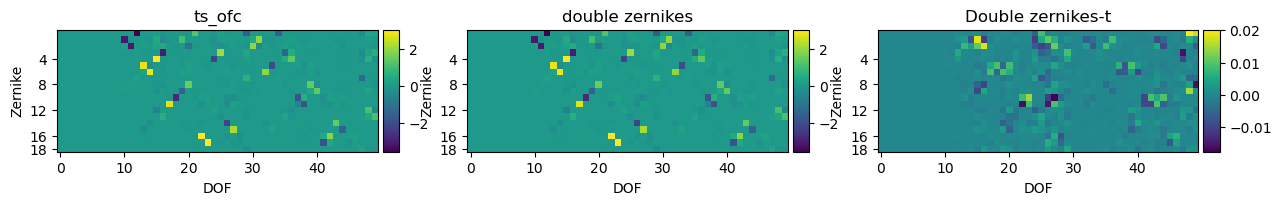

In [220]:
idof = 2
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
colorbar(axes[0].imshow(sen[idof, :, :50]))
colorbar(axes[1].imshow(field_sen0[:50, idof, :].T))
colorbar(axes[2].imshow(field_sen[:50, idof, :].T-sen[idof,:, :50]))
axes[0].set_title("ts_ofc")
axes[1].set_title("double zernikes")
axes[2].set_title("Double zernikes-t")
for ax in axes.ravel():
    ax.set_ylabel("Zernike")
    ax.set_xlabel("DOF")
    ax.set_yticks([4, 8, 12, 16, 18])


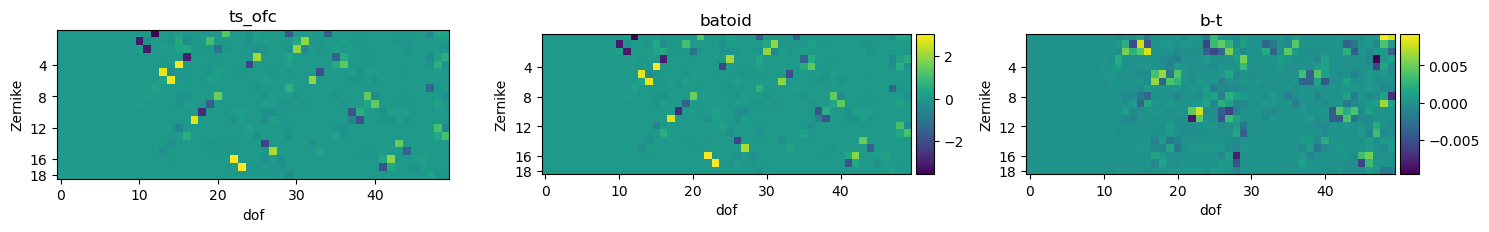

In [221]:
ifield = 2
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
axes[0].imshow(sen[ifield,...])
colorbar(axes[1].imshow(dz[ifield,...]))
colorbar(axes[2,].imshow(dz[ifield,...]-sen[ifield,...]))
axes[0].set_title("ts_ofc")
axes[1].set_title("batoid")
axes[2].set_title("b-t")
for ax in axes.ravel():
    ax.set_ylabel("Zernike")
    ax.set_xlabel("dof")
    ax.set_yticks([4, 8, 12, 16, 18])

fig.tight_layout()

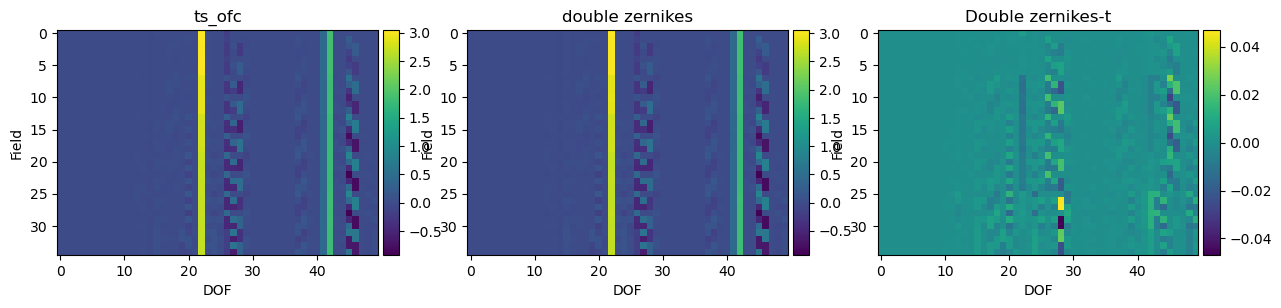

In [184]:
idof = 16
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
colorbar(axes[0].imshow(sen[:, idof, :]))
colorbar(axes[1].imshow(field_sen[:, :, idof].T))
colorbar(axes[2].imshow(field_sen[:, :, idof].T-sen[:, idof, :]))
axes[0].set_title("ts_ofc")
axes[1].set_title("double zernikes")
axes[2].set_title("Double zernikes-t")
for ax in axes.ravel():
    ax.set_ylabel("Field")
    ax.set_xlabel("DOF")

In [82]:
builder = batoid_rubin.LSSTBuilder(fiducial)
print(builder.fea_dir)

/sdf/home/g/gmegias/.local/lib/python3.11/site-packages/batoid_rubin/data/fea_legacy


In [84]:

print(bx)

[ 1.125995  4.043326  4.043326 ... -0.475801 -0.497489 -0.021687]


In [ ]:
def get_bending_mode(band, dof_idx):
    ndof = len(dof_idx)

    fiducial, wavelength = get_fiducial(band)
    
    for iarr, idof in enumerate(dof_idx):
        arr = np.zeros(50)

        arr[idof] = 1
        fiducial, wavelength = get_fiducial(band)
        builder = batoid_rubin.LSSTBuilder(fiducial).with_aos_dof(arr)
        telescope = builder.build()

        bx, by, idx1, idx3 = batoid_rubin.m1m3_fea_nodes(builder.fea_dir)
        surface = telescope['M1'].surface.sag(bx[idx1], by[idx1])
        surface0 = fiducial['M1'].surface.sag(bx[idx1], by[idx1])

        bend = surface - surface0

    return bend

In [38]:
Dofs = ['Camera dz', 'Camera dx', 'Camera dy', 'Camera Rx', 'Camera Ry',
        'M2 dz', 'M2 dx', 'M2 dy', 'M2 Rx', 'M2 Ry',
        'M1M3 Bending mode 1', 'M1M3 Bending mode 2', 'M1M3 Bending mode 3', 'M1M3 Bending mode 4', 'M1M3 Bending mode 5',
        'M1M3 Bending mode 6', 'M1M3 Bending mode 7', 'M1M3 Bending mode 8', 'M1M3 Bending mode 9', 'M1M3 Bending mode 10',
        'M1M3 Bending mode 11', 'M1M3 Bending mode 12', 'M1M3 Bending mode 13', 'M1M3 Bending mode 14', 'M1M3 Bending mode 15',
        'M1M3 Bending mode 16', 'M1M3 Bending mode 17', 'M1M3 Bending mode 18', 'M1M3 Bending mode 19', 'M1M3 Bending mode 20',
        'M2 Bending mode 1', 'M2 Bending mode 2', 'M2 Bending mode 3', 'M2 Bending mode 4', 'M2 Bending mode 5',
        'M2 Bending mode 6', 'M2 Bending mode 7', 'M2 Bending mode 8', 'M2 Bending mode 9', 'M2 Bending mode 10',
        'M2 Bending mode 11', 'M2 Bending mode 12', 'M2 Bending mode 13', 'M2 Bending mode 14', 'M2 Bending mode 15',
        'M2 Bending mode 16', 'M2 Bending mode 17', 'M2 Bending mode 18', 'M2 Bending mode 19', 'M2 Bending mode 20']

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


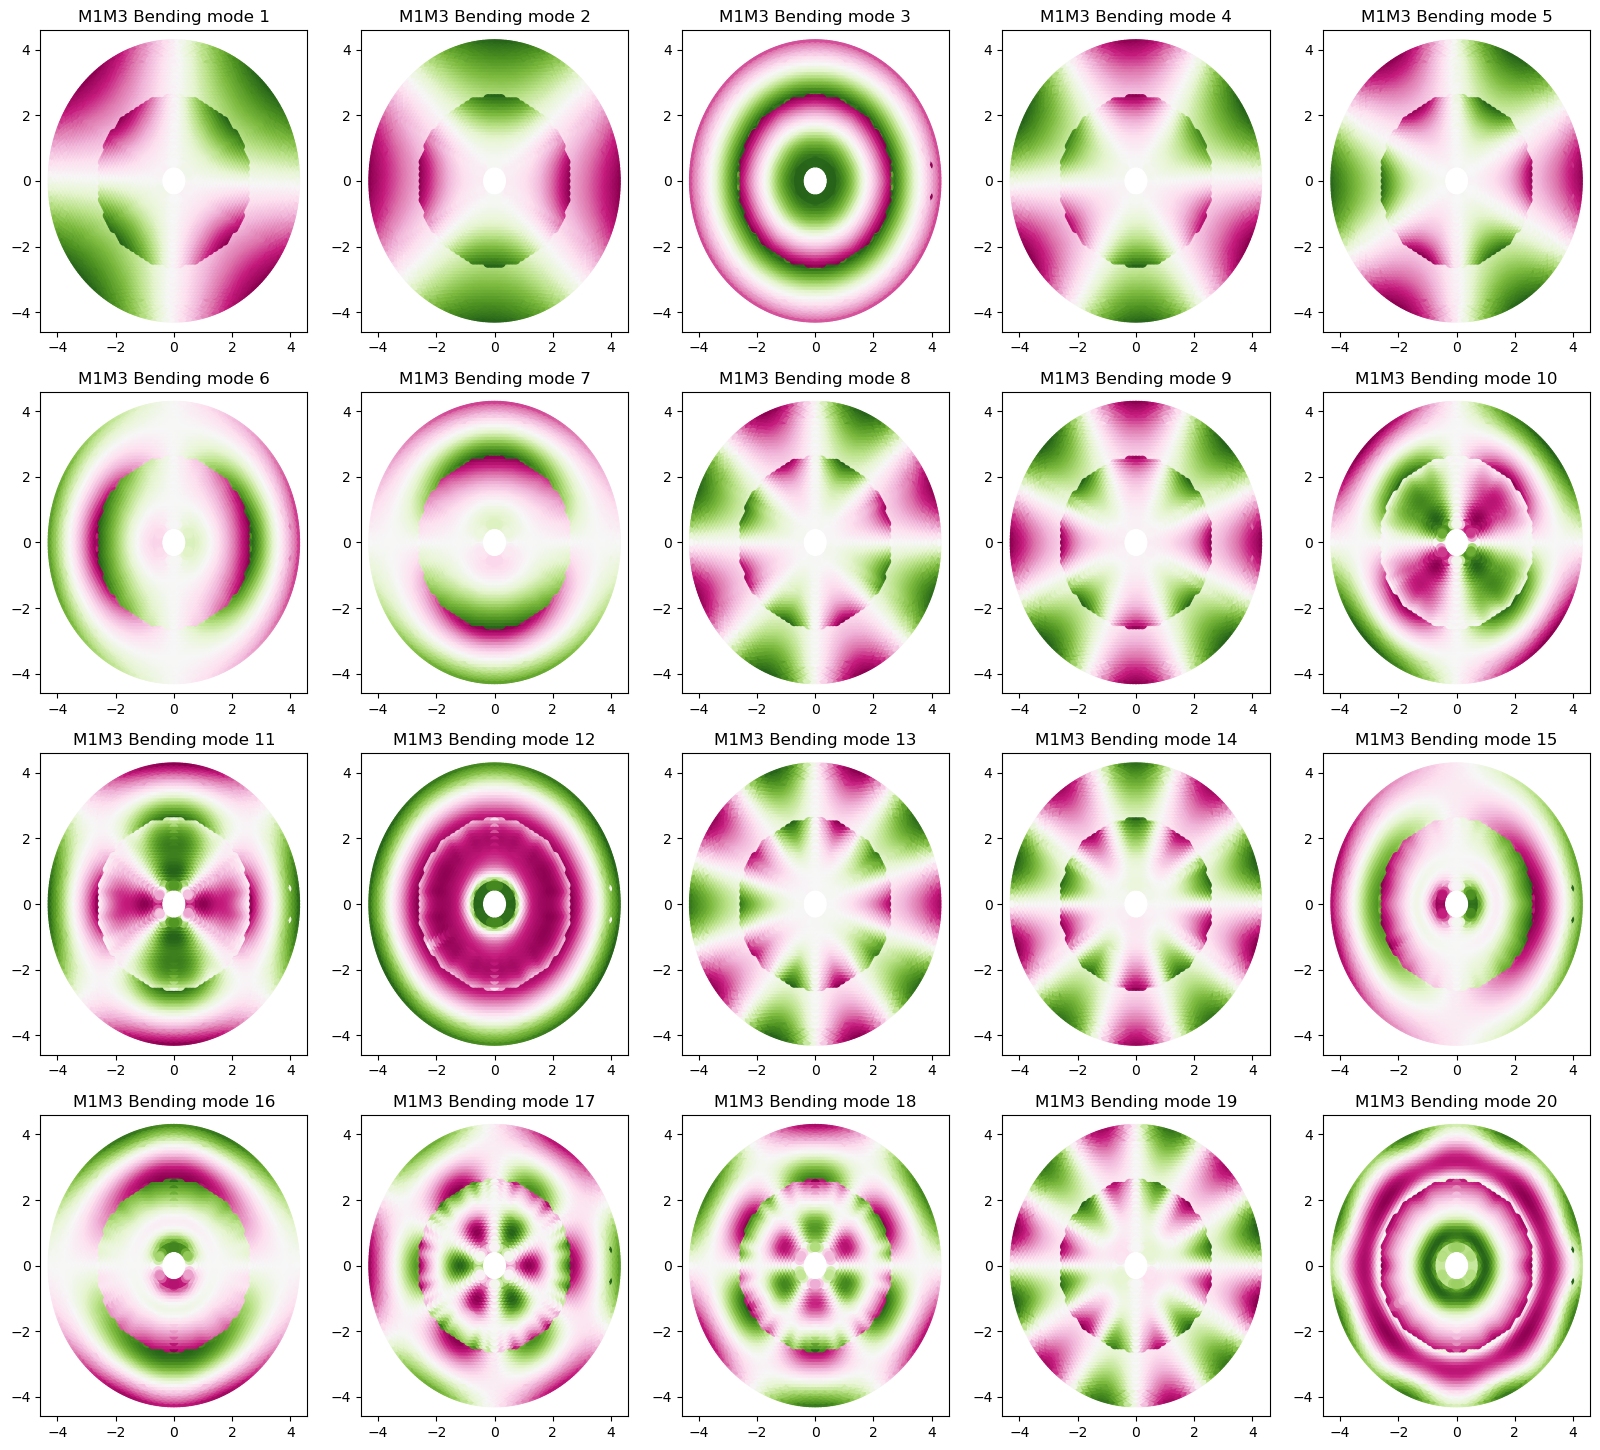

In [41]:
plt.figure(figsize = (20, 18))
for idx in np.arange(10,30):
    arr = np.zeros(50)
    idof = idx
    arr[idof] = 1
    fiducial, wavelength = get_fiducial('r')
    builder = batoid_rubin.LSSTBuilder(fiducial).with_aos_dof(arr)
    telescope = builder.build()

    bx, by, idx1, idx3 = batoid_rubin.m1m3_fea_nodes(builder.fea_dir)

    surface_m1 = telescope['M1'].surface.sag(bx[idx1], by[idx1])
    surface0_m1 = fiducial['M1'].surface.sag(bx[idx1], by[idx1])
    bend_m1 = surface_m1 - surface0_m1


    surface_m3 = telescope['M3'].surface.sag(bx[idx3], by[idx3])
    surface0_m3 = fiducial['M3'].surface.sag(bx[idx3], by[idx3])
    bend_m3 = surface_m3 - surface0_m3

    plt.subplot(4,5,idx - 9)
    plt.scatter(bx[idx1], by[idx1], c=bend_m1, cmap = 'PiYG')
    plt.scatter(bx[idx3], by[idx3], c=bend_m3, cmap = 'PiYG')

    plt.title(f'{Dofs[idx]}')